# Deep Learning: Sentiment Analysis

- Let's get back to the Senitment Analysis on the NLTK Movie Reviews datasets 

![](../images/keras-workflow.png)

## Prepare Data

In [1]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text,1) if label=="pos" else (text, 0) for (text, label) in documents]

random.shuffle(documents)

# labeled_names = ([(name, 1) for name in names.words('male.txt')] +
#                  [(name, 0) for name in names.words('female.txt')])
# random.shuffle(labeled_names)

In [3]:
documents[1]

('louie is a trumpeter swan with no voice . in order to woo his lady love serina , louie makes friends with a young boy , sammy , who persuades teacher mrs . hammerbottom ( carol burnett ) to allow louie to attend class . louie learns to read and write and returns to his flock , but is laughed at once again when no other swans can understand his message of love for serina . to make matters worse , louie \' s father feels he \' s lost his honor because of the trumpet he stole for his son in this animated version of e . b . white \' s " trumpet of the swan . " as jane austen and henry james have become popular sources for adult filmmakers over the past decade or so , e . b . white is being returned to for children \' s films . the animated " charlotte \' s web " has become a minor classic since its release in 1973 and 1999 brought us a live action version of " stuart little . " " trumpet of the swan , " directed by richard rich ( 1999 \' s animated " the king and i , " the " swan princes

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents, test_size = 0.1, random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- In deep learning, words or characters are automatically converted into numeric representations.
- In other words, the feature engineering step is fully automatic.

- Steps:
    - Text to Integers
    - Padding each instance to be of same lengths
    

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Bidirectional

In [6]:
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set] 

In [7]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- By default, the token index 0 is reserved for padding token.
- If `oov_token` is specified, it is default to index 1.
- Specify `num_words` for tokenizer to include only top N words in the model
- Tokenizer will automatically remove puntuations.
- Tokenizer use whitespace as word delimiter.
- If every character is treated as a token, specify `char_level=True`.

In [8]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- if `oov_token` is specified, then the vocabulary size needs to be added one more.

In [9]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 10001


In [10]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('this', 15),
 ('his', 16),
 ('film', 17),
 ('i', 18),
 ('he', 19),
 ('but', 20)]

In [11]:
len(tokenizer.word_index)

37839

## Text Vectorization

### From Texts and Tensors

- Like in feature-based machine translation, a computational model only accepts numeric values. It is necessary to convert raw text to numeric tensor for neural network.
- There are two main ways of text vectorization:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of tokens in texts and learn token **embeddings**

## Define X and Y

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [12]:
texts_ints = tokenizer.texts_to_sequences(texts)

#### Padding

- To make sure each input text consists of the same number of tokens.

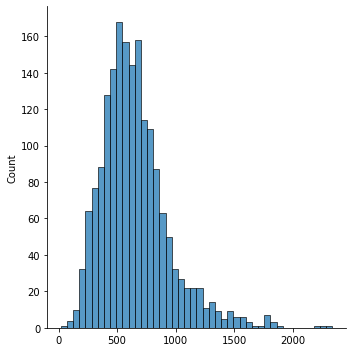

In [13]:
texts_lens=[len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)
#print(texts[np.argmax(texts_lens)]) # longest name

In [14]:
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2338

- We consider the final 400 tokens of each text.
- `padding` and `truncating` parameters in `pad_sequences`: whether to Pre-padding or removing values from the beginning of the sequence (i.e., `pre`) or the other way (`post`).

In [15]:
max_len = 400

In [16]:
texts_ints_pad = sequence.pad_sequences(texts_ints, maxlen = max_len, truncating='pre', padding='pre')
texts_ints_pad[:10]

array([[9481,    5,    2, ...,    6,   23,  973],
       [   8,    2, 2133, ...,   69,    3,   68],
       [2446,   12,    2, ...,   42,    4,  252],
       ...,
       [   0,    0,    0, ...,    1,  271,  775],
       [7331,   19,    7, ...,   14,   66, 1570],
       [ 336,  358,    4, ...,    1,  912, 5283]], dtype=int32)

In [17]:
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(
        [n for (n, l) in test_set]),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

X_test_texts = [n for (n, l) in test_set]

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding)

- text to matrix (one-hot encode)
- choose modes for bag-of-words (binary, count, tfidf)

In [19]:
texts_matrix = tokenizer.texts_to_matrix(texts, mode="count")

In [20]:
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

X_test2 = tokenizer.texts_to_matrix([n for (n,l) in test_set], mode="count").astype('int32')
y_test2 = np.array([l for (n,l) in test_set])

X_test2_texts = [n for (n,l) in test_set]

In [21]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Model Definition

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

In [23]:
from keras import layers
model1 = keras.Sequential()
model1.add(keras.Input(shape=(NUM_WORDS,)))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model1.add(layers.Dense(2, activation="softmax", name="output"))

model1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)


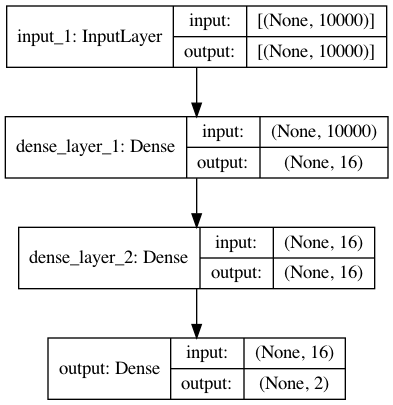

In [24]:
plot_model(model1, show_shapes=True )

In [25]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2

In [26]:
history1 = model1.fit(X_train2, y_train2, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 2s - loss: 0.6614 - accuracy: 0.6083 - val_loss: 0.6106 - val_accuracy: 0.6833
Epoch 2/25
12/12 - 0s - loss: 0.4582 - accuracy: 0.8403 - val_loss: 0.4694 - val_accuracy: 0.8000
Epoch 3/25
12/12 - 0s - loss: 0.2807 - accuracy: 0.9319 - val_loss: 0.3761 - val_accuracy: 0.8556
Epoch 4/25
12/12 - 0s - loss: 0.1655 - accuracy: 0.9757 - val_loss: 0.3237 - val_accuracy: 0.8778
Epoch 5/25
12/12 - 0s - loss: 0.0861 - accuracy: 0.9944 - val_loss: 0.3025 - val_accuracy: 0.8861
Epoch 6/25
12/12 - 0s - loss: 0.0472 - accuracy: 0.9986 - val_loss: 0.2976 - val_accuracy: 0.8778
Epoch 7/25
12/12 - 0s - loss: 0.0253 - accuracy: 0.9993 - val_loss: 0.3034 - val_accuracy: 0.8806
Epoch 8/25
12/12 - 0s - loss: 0.0152 - accuracy: 0.9993 - val_loss: 0.3090 - val_accuracy: 0.8889
Epoch 9/25
12/12 - 0s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.3147 - val_accuracy: 0.8889
Epoch 10/25
12/12 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.3228 - val_accuracy: 0.8889
Epoch 11/25
12/12 -

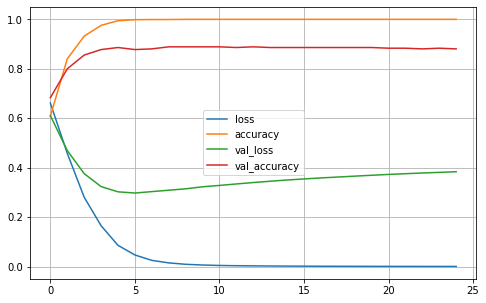

In [27]:
plot2(history1)

In [28]:
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.4423 - accuracy: 0.8500


[0.44230666756629944, 0.8500000238418579]

### Model 2

- One Embedding Layer + Two layers of fully-connected dense layers
- The Input is the integer encodings of texts from the padded text-to-sequence.

In [29]:
EMBEDDING_DIM = 128
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model2.add(layers.GlobalAveragePooling1D()) ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model2.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model2.add(layers.Dense(2, activation="softmax", name="output"))

model2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

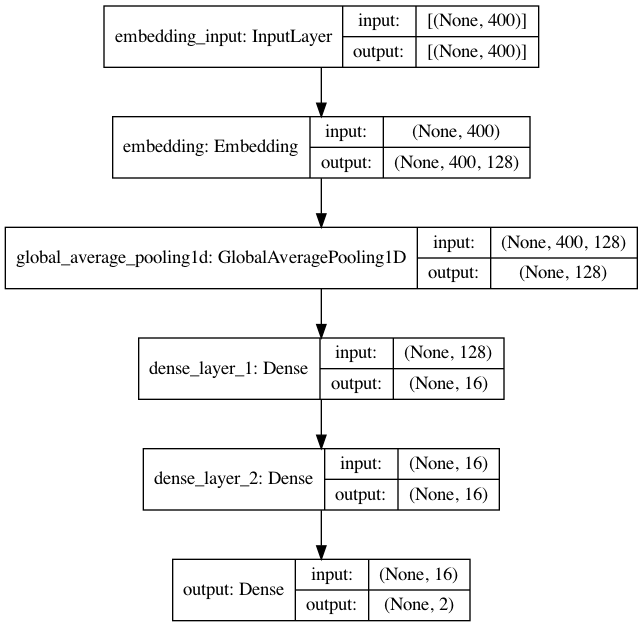

In [30]:
plot_model(model2, show_shapes=True)

In [31]:
history2 = model2.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6920 - accuracy: 0.5889 - val_loss: 0.6889 - val_accuracy: 0.7306
Epoch 2/25
12/12 - 0s - loss: 0.6837 - accuracy: 0.8076 - val_loss: 0.6811 - val_accuracy: 0.6722
Epoch 3/25
12/12 - 0s - loss: 0.6680 - accuracy: 0.8243 - val_loss: 0.6646 - val_accuracy: 0.8083
Epoch 4/25
12/12 - 0s - loss: 0.6395 - accuracy: 0.8687 - val_loss: 0.6388 - val_accuracy: 0.8222
Epoch 5/25
12/12 - 0s - loss: 0.5945 - accuracy: 0.8882 - val_loss: 0.6009 - val_accuracy: 0.8139
Epoch 6/25
12/12 - 0s - loss: 0.5306 - accuracy: 0.9167 - val_loss: 0.5591 - val_accuracy: 0.7750
Epoch 7/25
12/12 - 0s - loss: 0.4453 - accuracy: 0.9319 - val_loss: 0.4957 - val_accuracy: 0.8278
Epoch 8/25
12/12 - 0s - loss: 0.3507 - accuracy: 0.9528 - val_loss: 0.4370 - val_accuracy: 0.8306
Epoch 9/25
12/12 - 0s - loss: 0.2570 - accuracy: 0.9715 - val_loss: 0.3847 - val_accuracy: 0.8556
Epoch 10/25
12/12 - 1s - loss: 0.1810 - accuracy: 0.9819 - val_loss: 0.3490 - val_accuracy: 0.8444
Epoch 11/25
12/12 -

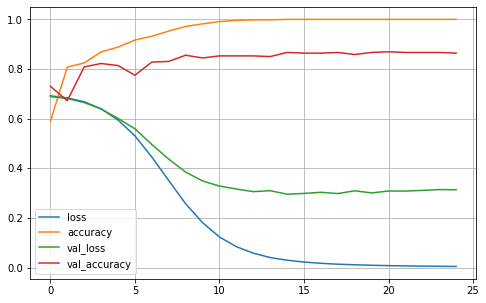

In [32]:
plot2(history2)

In [33]:
model2.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 0.3609 - accuracy: 0.8350


[0.3608708679676056, 0.8349999785423279]

## Check Embeddings

- Compared to one-hot encodings of characters, embeddings may include more information relating to the characteristics of the characters.
- We can extract the embedding layer and apply dimensional reduction techniques (i.e., TSNE) to see how embeddings capture the relationships in-between characters.

In [34]:
ind2word = tokenizer.index_word

In [35]:
# check first N words for text
' '.join([ind2word.get(i) for i in X_test[1][-50:] if ind2word.get(i)!= None])

"s no phantom menace but if you ' re looking for a solid warm up to the summer movie season you won ' t find a better film under wraps than the mummy if this doesn ' t give fraser from blast from the past and man then nothing will"

In [36]:
X_test_texts[1][-287:]

"as well . no , it ' s no phantom menace beater , but if you ' re looking for a solid warm - up to the summer movie season , you won ' t find a better film under wraps than the mummy . if this doesn ' t give fraser forgiveness from blast from the past and encino man , then nothing will ."

In [37]:
word_vectors = model2.layers[0].get_weights()[0]
word_vectors.shape

(10001, 128)

In [38]:
token_labels = [word for (ind, word) in tokenizer.index_word.items()]
token_labels.insert(0,None)
token_labels[:10]

[None, 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

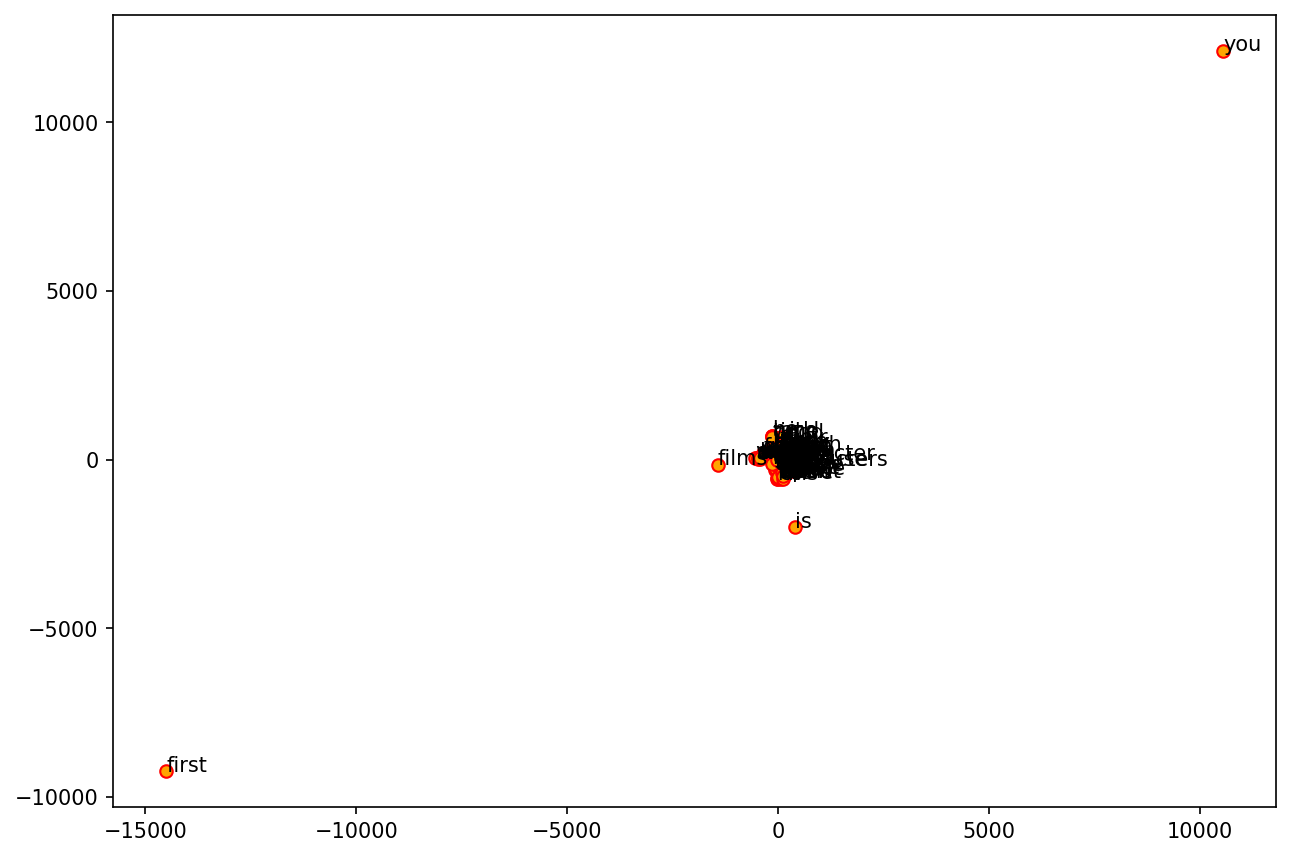

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[:100,])
labels = labels

plt.figure(figsize=(10, 7), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(token_labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+0.01, y+0.01), xytext=(0, 0), textcoords='offset points')

## Issues of Word/Character Representations

- One-hot encoding does not indicate semantic relationships between characters.
- For deep learning NLP, it is preferred to convert one-hot encodings of words/characters into embeddings, which are argued to include more semantic information of the tokens.
- Now the question is how to train and create better word embeddings. We will come back to this issue later.

- Generally speaking, we can train our word embeddings along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these later.

## Hyperparameter Tuning

:::{note}

Please install keras tuner module in your current conda:
```
pip install -U keras-tuner
```

:::

- Like feature-based ML methods, neural networks also come with many hyperparameters, which require default values.
- Typical hyperparameters include:
    - Number of nodes for the layer
    - Learning Rates
- We can utilize the module, [`keras-tuner`](https://keras-team.github.io/keras-tuner/documentation/tuners/), to fine-tune the hyperparameters.

- Steps for Keras Tuner
    - First, wrap the model definition in a function, which takes a single `hp` argument. 
    - Inside this function, replace any value we want to tune with a call to hyperparameter sampling methods, e.g. `hp.Int()` or `hp.Choice()`. The function should return a compiled model.
    - Next, instantiate a tuner object specifying your optimization objective and other search parameters.
    - Finally, start the search with the `search()` method, which takes the same arguments as `Model.fit()` in keras.
    - When search is over, we can retrieve the best model and a summary of the results from the `tunner`.


In [40]:
import kerastuner

In [41]:
## Wrap model definition in a function
## and specify the parameters needed for tuning
def build_model(hp):
    model1 = keras.Sequential()
    model1.add(keras.Input(shape=(max_len,)))
    model1.add(layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu", name="dense_layer_1"))
    model1.add(layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu", name="dense_layer_2"))
    model1.add(layers.Dense(2, activation="softmax", name="output"))
    model1.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model1

# def build_model(hp):
#     inputs = keras.Input(shape=(784,))
#     x = layers.Dense(
#         units=hp.Int('units', min_value=32, max_value=512, step=32),
#         activation='relu'))(inputs)
#     outputs = layers.Dense(10, activation='softmax')(x)
#     model = keras.Model(inputs, outputs)
#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Choice('learning_rate',
#                       values=[1e-2, 1e-3, 1e-4])),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy'])
#     return model

In [42]:
## This is to clean up the temp dir from the tuner
## Every time we re-start the tunner, it's better to keep the temp dir clean

import os
import shutil

if os.path.isdir('my_dir'):
    shutil.rmtree('my_dir')
    

In [43]:
## Instantiate the tunner

tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_accuracy',
  max_trials=10,
  executions_per_trial=3,
  directory='my_dir')

In [44]:
## Check the tuner's search space
tuner.search_space_summary()

In [45]:
## Start tuning with the tuner
tuner.search(X_train, y_train, validation_split=0.2, batch_size=128)

12/12 [==============================] - ETA: 3s - loss: 700.2605 - accuracy: 0.52 - 1s 18ms/step - loss: 571.3211 - accuracy: 0.5253 - val_loss: 359.7315 - val_accuracy: 0.4722


12/12 [==============================] - 0s 18ms/step - loss: 714.1545 - accuracy: 0.4959 - val_loss: 826.5114 - val_accuracy: 0.4556


12/12 [==============================] - 0s 18ms/step - loss: 802.7193 - accuracy: 0.5094 - val_loss: 884.2908 - val_accuracy: 0.4833


12/12 [==============================] - 1s 18ms/step - loss: 513.3826 - accuracy: 0.4983 - val_loss: 303.5842 - val_accuracy: 0.5139


12/12 [==============================] - 1s 18ms/step - loss: 984.0882 - accuracy: 0.5034 - val_loss: 161.1141 - val_accuracy: 0.5028


12/12 [==============================] - 1s 20ms/step - loss: 635.5410 - accuracy: 0.5315 - val_loss: 684.1140 - val_accuracy: 0.5028


12/12 [==============================] - 1s 18ms/step - loss: 862.4046 - accuracy: 0.5328 - val_loss: 185.0148 - val_accuracy: 0.5111


12/12 [==============================] - 1s 21ms/step - loss: 598.5976 - accuracy: 0.4975 - val_loss: 550.8841 - val_accuracy: 0.5194


12/12 [==============================] - 1s 19ms/step - loss: 594.6885 - accuracy: 0.4818 - val_loss: 418.0426 - val_accuracy: 0.4917


12/12 [==============================] - 0s 18ms/step - loss: 1587.7101 - accuracy: 0.5039 - val_loss: 58.8479 - val_accuracy: 0.4806


INFO:tensorflow:Oracle triggered exit


In [46]:
## Retrieve the best models from the tuner
models = tuner.get_best_models(num_models=2)

In [47]:
## Retrieve the summary of results from the tuner
tuner.results_summary()

## Sequence Models

### Model 3

- One Embedding Layer + LSTM + Dense Layer
- Input: the padded text-to-sequences

In [48]:
EMBEDDING_DIM = 128
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
#model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(16, dropout=0.5, recurrent_dropout=0.5))
model3.add(Dense(2, activation="softmax"))

model3.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

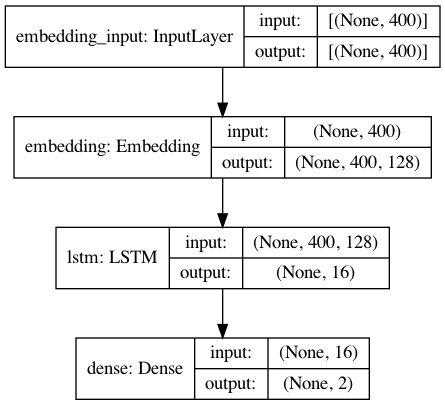

In [49]:
plot_model(model3, show_shapes=True)

In [50]:
history3 = model3.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6927 - accuracy: 0.5208 - val_loss: 0.6906 - val_accuracy: 0.5361
Epoch 2/25
12/12 - 5s - loss: 0.6736 - accuracy: 0.6868 - val_loss: 0.6875 - val_accuracy: 0.5333
Epoch 3/25
12/12 - 5s - loss: 0.6444 - accuracy: 0.7688 - val_loss: 0.6773 - val_accuracy: 0.5528
Epoch 4/25
12/12 - 5s - loss: 0.5770 - accuracy: 0.8250 - val_loss: 0.6513 - val_accuracy: 0.6111
Epoch 5/25
12/12 - 5s - loss: 0.4308 - accuracy: 0.8611 - val_loss: 0.5846 - val_accuracy: 0.6972
Epoch 6/25
12/12 - 5s - loss: 0.2627 - accuracy: 0.9021 - val_loss: 0.5557 - val_accuracy: 0.7306
Epoch 7/25
12/12 - 5s - loss: 0.1660 - accuracy: 0.9632 - val_loss: 0.5958 - val_accuracy: 0.7667
Epoch 8/25
12/12 - 5s - loss: 0.1175 - accuracy: 0.9660 - val_loss: 0.6150 - val_accuracy: 0.7528
Epoch 9/25
12/12 - 5s - loss: 0.0852 - accuracy: 0.9840 - val_loss: 0.6179 - val_accuracy: 0.7583
Epoch 10/25
12/12 - 5s - loss: 0.0590 - accuracy: 0.9882 - val_loss: 0.6998 - val_accuracy: 0.7389
Epoch 11/25
12/12 -

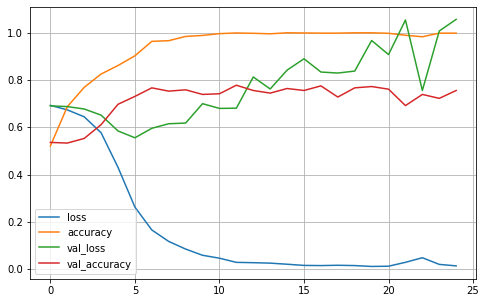

In [51]:
plot2(history3)

In [52]:
model3.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 0.9035 - accuracy: 0.7850


[0.9034587144851685, 0.7850000262260437]

### Model 4

- One Embedding Layer + Two Stacked LSTM + Dense Layer

In [53]:
EMBEDDING_DIM = 128
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.5)) #)
model4.add(LSTM(16, dropout=0.1, recurrent_dropout=0.5))
model4.add(Dense(2, activation="softmax"))

model4.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

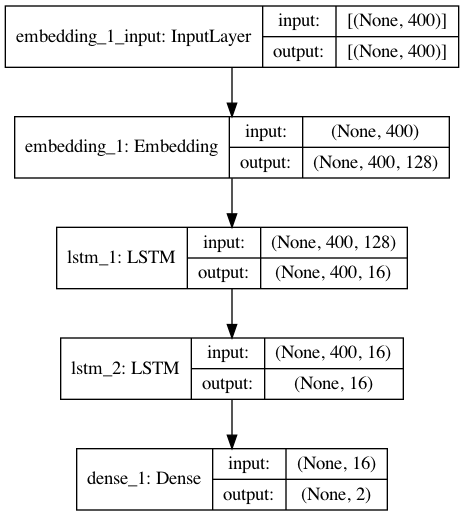

In [54]:
plot_model(model4,show_shapes=True)

In [55]:
history4 = model4.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = 0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6923 - accuracy: 0.5160 - val_loss: 0.6907 - val_accuracy: 0.5389
Epoch 2/25
12/12 - 8s - loss: 0.6766 - accuracy: 0.7639 - val_loss: 0.6792 - val_accuracy: 0.6278
Epoch 3/25
12/12 - 8s - loss: 0.6072 - accuracy: 0.8299 - val_loss: 0.6316 - val_accuracy: 0.6250
Epoch 4/25
12/12 - 8s - loss: 0.3965 - accuracy: 0.8611 - val_loss: 0.6328 - val_accuracy: 0.7028
Epoch 5/25
12/12 - 8s - loss: 0.1967 - accuracy: 0.9382 - val_loss: 0.6822 - val_accuracy: 0.7000
Epoch 6/25
12/12 - 8s - loss: 0.0956 - accuracy: 0.9792 - val_loss: 0.7946 - val_accuracy: 0.7083
Epoch 7/25
12/12 - 8s - loss: 0.0715 - accuracy: 0.9812 - val_loss: 0.8372 - val_accuracy: 0.6972
Epoch 8/25
12/12 - 8s - loss: 0.0441 - accuracy: 0.9944 - val_loss: 0.8790 - val_accuracy: 0.7250
Epoch 9/25
12/12 - 8s - loss: 0.0287 - accuracy: 0.9965 - val_loss: 0.9462 - val_accuracy: 0.7222
Epoch 10/25
12/12 - 8s - loss: 0.0195 - accuracy: 0.9986 - val_loss: 1.0200 - val_accuracy: 0.7222
Epoch 11/25
12/12 

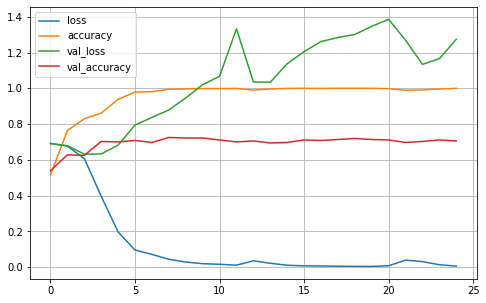

In [56]:
plot2(history4)

### Model 5

- Embedding Layer + Bidirectional LSTM + Dense Layer

In [57]:
EMBEDDING_DIM = 128
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
#model3.add(SpatialDropout1D(0.2))
model5.add(Bidirectional(LSTM(16, dropout=0.5, recurrent_dropout=0.5)))
model5.add(Dense(2, activation="softmax"))

model5.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

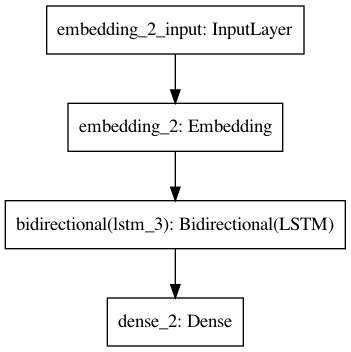

In [58]:
plot_model(model5)

In [59]:
history5 = model5.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = 0.2)

Epoch 1/25
12/12 - 13s - loss: 0.6933 - accuracy: 0.5063 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/25
12/12 - 7s - loss: 0.6770 - accuracy: 0.7347 - val_loss: 0.6911 - val_accuracy: 0.5389
Epoch 3/25
12/12 - 7s - loss: 0.6525 - accuracy: 0.8479 - val_loss: 0.6875 - val_accuracy: 0.5694
Epoch 4/25
12/12 - 7s - loss: 0.6007 - accuracy: 0.8889 - val_loss: 0.6742 - val_accuracy: 0.6028
Epoch 5/25
12/12 - 7s - loss: 0.4704 - accuracy: 0.9083 - val_loss: 0.5915 - val_accuracy: 0.6750
Epoch 6/25
12/12 - 7s - loss: 0.2893 - accuracy: 0.8958 - val_loss: 0.5623 - val_accuracy: 0.7083
Epoch 7/25
12/12 - 7s - loss: 0.1642 - accuracy: 0.9736 - val_loss: 0.5506 - val_accuracy: 0.7306
Epoch 8/25
12/12 - 7s - loss: 0.0877 - accuracy: 0.9833 - val_loss: 0.5594 - val_accuracy: 0.7667
Epoch 9/25
12/12 - 7s - loss: 0.0501 - accuracy: 0.9931 - val_loss: 0.5763 - val_accuracy: 0.7639
Epoch 10/25
12/12 - 7s - loss: 0.0313 - accuracy: 0.9979 - val_loss: 0.6220 - val_accuracy: 0.7667
Epoch 11/25
12/12 

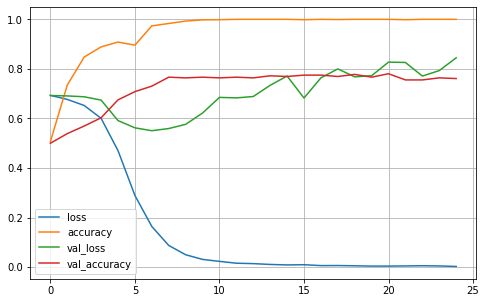

In [60]:
plot2(history5)

### Model 6

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer

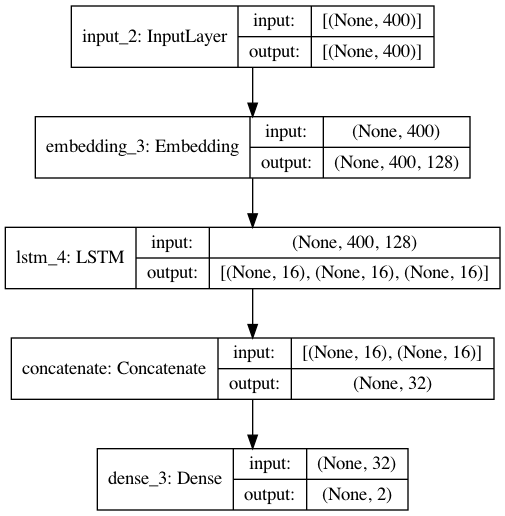

In [61]:
EMBEDDING_DIM = 128

inputs = keras.Input(shape=(max_len,))
x=layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True)(inputs)
#x=layers.SpatialDropout1D(0.2)(x)
x_all_h,x_last_h, x_c = layers.LSTM(16, dropout=0.2, 
                               recurrent_dropout=0.5, 
                               return_sequences=False, return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = layers.Concatenate(axis=1)([x_last_h, x_c])
outputs=layers.Dense(2, activation='softmax')(x)
model6 = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

plot_model(model6, show_shapes=True)

In [62]:
model6.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
history6 = model6.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6915 - accuracy: 0.5340 - val_loss: 0.6871 - val_accuracy: 0.5861
Epoch 2/25
12/12 - 4s - loss: 0.6607 - accuracy: 0.7840 - val_loss: 0.6758 - val_accuracy: 0.6278
Epoch 3/25
12/12 - 4s - loss: 0.5910 - accuracy: 0.8479 - val_loss: 0.6429 - val_accuracy: 0.6528
Epoch 4/25
12/12 - 4s - loss: 0.4206 - accuracy: 0.8896 - val_loss: 0.5492 - val_accuracy: 0.7222
Epoch 5/25
12/12 - 4s - loss: 0.2548 - accuracy: 0.9187 - val_loss: 0.5544 - val_accuracy: 0.7361
Epoch 6/25
12/12 - 4s - loss: 0.1370 - accuracy: 0.9681 - val_loss: 0.5728 - val_accuracy: 0.7417
Epoch 7/25
12/12 - 4s - loss: 0.0695 - accuracy: 0.9868 - val_loss: 0.7368 - val_accuracy: 0.7361
Epoch 8/25
12/12 - 4s - loss: 0.0343 - accuracy: 0.9951 - val_loss: 0.7412 - val_accuracy: 0.7472
Epoch 9/25
12/12 - 4s - loss: 0.0249 - accuracy: 0.9951 - val_loss: 0.7797 - val_accuracy: 0.7500
Epoch 10/25
12/12 - 4s - loss: 0.0163 - accuracy: 0.9979 - val_loss: 0.8800 - val_accuracy: 0.7389
Epoch 11/25
12/12 -

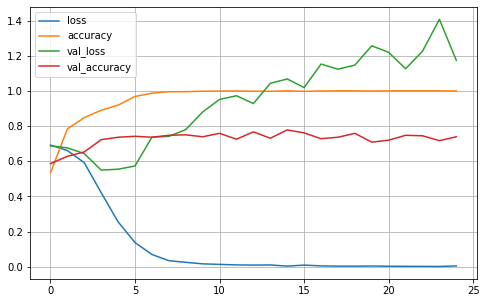

In [63]:
plot2(history6)

In [64]:
model6.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 1.0375 - accuracy: 0.7650


[1.0374811887741089, 0.7649999856948853]

### Model 7

- Adding AttentionLayer
    - Use the hidden state h of the last time step and the cell state c of the last time step
    - Check their attention
    - And use [attention out + hidden state h of the last time step] for decision

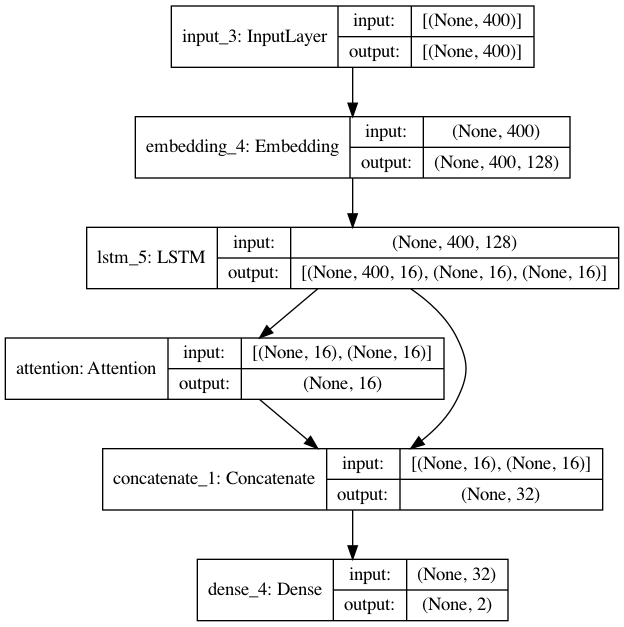

In [65]:
EMBEDDING_DIM = 128

inputs = keras.Input(shape=(max_len,))
x=layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len)(inputs)
#x=layers.SpatialDropout1D(0.2)(x)
x_all_hs, x_last_h, x_last_c = layers.LSTM(16, dropout=0.2, 
                               recurrent_dropout=0.5, 
                               return_sequences=True, return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden state of the last time step
#     (2) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (3) the cell state of the last time step


atten_out = layers.Attention()([x_last_h, x_last_c])

x = layers.Concatenate(axis=1)([x_last_h, atten_out])
outputs=layers.Dense(2, activation='softmax')(x)
model7 = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

plot_model(model7, show_shapes=True)

In [66]:
model7.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
history7 = model7.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 7s - loss: 0.6929 - accuracy: 0.5014 - val_loss: 0.6910 - val_accuracy: 0.5333
Epoch 2/25
12/12 - 4s - loss: 0.6765 - accuracy: 0.7354 - val_loss: 0.6849 - val_accuracy: 0.6028
Epoch 3/25
12/12 - 4s - loss: 0.6472 - accuracy: 0.8146 - val_loss: 0.6715 - val_accuracy: 0.6083
Epoch 4/25
12/12 - 4s - loss: 0.5726 - accuracy: 0.8674 - val_loss: 0.6309 - val_accuracy: 0.6583
Epoch 5/25
12/12 - 4s - loss: 0.4044 - accuracy: 0.8931 - val_loss: 0.5842 - val_accuracy: 0.7278
Epoch 6/25
12/12 - 4s - loss: 0.2294 - accuracy: 0.9201 - val_loss: 0.5840 - val_accuracy: 0.7111
Epoch 7/25
12/12 - 4s - loss: 0.1235 - accuracy: 0.9715 - val_loss: 0.6370 - val_accuracy: 0.7333
Epoch 8/25
12/12 - 4s - loss: 0.0688 - accuracy: 0.9812 - val_loss: 1.0467 - val_accuracy: 0.6750
Epoch 9/25
12/12 - 4s - loss: 0.0735 - accuracy: 0.9771 - val_loss: 0.6922 - val_accuracy: 0.7333
Epoch 10/25
12/12 - 4s - loss: 0.0415 - accuracy: 0.9889 - val_loss: 0.8119 - val_accuracy: 0.7250
Epoch 11/25
12/12 -

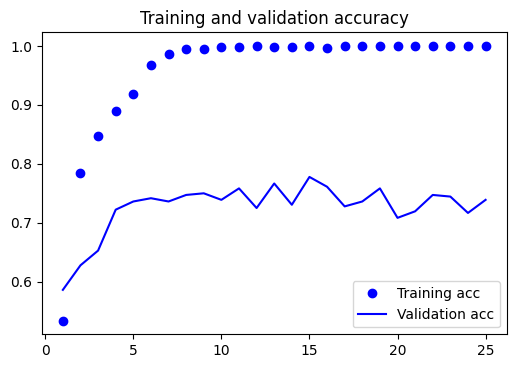

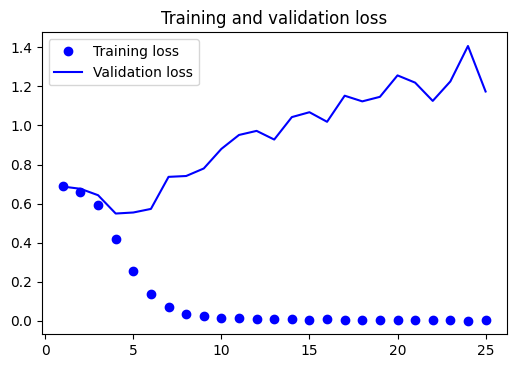

In [67]:
plot(history6)

## Explanation

In [68]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['negative','positive'], char_level=False)

In [69]:
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    #return np.array([[float(1-x), float(x)] for x in model.predict(np.array(_seq_pad))])
    return model2.predict(np.array(_seq_pad))



# np.array(sequence.pad_sequences(
#     tokenizer.texts_to_sequences([n for (n,l) in test_set]),
#     maxlen = max_len)).astype('float32')

In [70]:
reversed_word_index = dict([(index, word) for (word, index) in tokenizer.word_index.items()])

In [71]:
text_id =150

In [72]:
X_test[text_id]

array([   7, 1440,   12,  666,   12,    1,  223, 1155,   26, 5301,  577,
          4, 1356,    3,   41,   66,  102,   29,  637,  228,  125,   31,
         67,  132,  265,    3,  415,   39,  175,  351,   97,   15,   27,
        133,   62,  257,   74,    5,  144,  102,   29,  432,    5,  132,
          5,    1, 3102,  228,  125,  116,    6,   23,    1,  400,   29,
       1727,    1,   27,   13,  104,   93,    5,  132, 1440,    3, 1440,
         52, 1939,   28,  666, 2659,   40,    7,   62,   65,    5,  156,
          2,  148,  118,   87,  215,  852,   66,  418,  125, 1009, 2811,
          1, 1089, 1947,   96,   30,  432,    5, 2022,  118,  148,    1,
        691,    3,    1,  124,   13, 3698, 2348,  152,  107,    7, 3020,
          3, 2117,    2,  999,   29,  626,    5,   85,    1, 4038,   35,
          2,  134,  583,  107,  148, 1009, 2288,   43,  234,   15,  418,
         18,   35,  159,   61,   26,   27,   29, 4780, 2853,   21,  108,
       1030,    4,  125,   18,    6,  245, 1294,   

In [73]:
X_test_texts[text_id]

'i think the first thing this reviewer should mention is wether or not i am a fan of the x - files . first , let me assure you that no prior experience with the series is required to fully enjoy this movie . the producers are not stupid , making a movie just for fans of the series is not profitable . you have to reach for a larger audience . therefore , the movie is quite user - friendly . altough , non - fans will only fail to understand certain emotions behind the looks many characters exchange . but fear not , duchovny and another man later on provide more than adequate background info on what is going on . you will never feel as if you just walked in on the third act of some great opera . in any case , the answer is no . i am not a fan of the x - files , i only watch it when nothing else is on and i prefer millennium . however , since the fox network as been so kind as to air several key episodes for several weeks before the movie \' s opening weekend i took that opportunity to tes

In [74]:
' '.join([reversed_word_index.get(i, '?') for i in X_test[text_id]])

"is twice as important as the effects miss one vital piece of information and like most people who talk during movies you will go home and tell all your friends how this movie made no sense also to those people who need to go to the bathroom during movies don ' t the person who watched the movie with me had to go twice and twice she missed an important conversation there is no time to take a between scenes because again unlike most summer movies godzilla anybody the x files does not need to fill scenes between the suspense and the action with useless subplots every scene is crucial and serves a purpose who needs to see the blond have a big emotional scene between godzilla attacks so far this summer i have seen only one movie who ranks higher on my list of movies i ' d recommend and that is the truman show but it only wins by a nose but the truman show is not what i would call a summer movie the x files is what more do you ask from a summer movie other than the chance to be excited cool

In [75]:
print(X_test[22])
print(X_test_texts[22])

[  11   10    6    9   55    3 7988    3   31    6  177  292    5  199
   45   13  136  153   63   11   40  121   55   91  120  174    8   15
   27   11   57    6  177   39  159  146   34    1 2144  100 4502    4
 3996 7087 2679  281 3996 1878  380  219   78    1  311  347    1  326
  519  135   14    2  176 2448  219   33   46  806   63    1  176  162
  253    6   23  115   55  914  281    8   26  237   33   18   42  543
  196   18   75    2  150  260  543   20  162   18   75   90 5071   48
   40    7   62  162   48   40 1877    6   23 3027 3621   11  121   40
   14   62   78  321   63   14    1  773  809   49  490    6   23   11
   64  357 1813  104    3    1 2448    1   17   33  823   13 8085 1818
  284    1   83  121 1119 1056    3 2181   30    5 1282 3218  758   31
    6  177  292    2  802    4  102  164 1419    8   50  428    4  222
   36    6  128  930  158    5  132    5    2  796   53 3417 5361   82
    5 1855   36 1257    2  791 1688   56   36 1658    1  309   18  330
   62 

In [76]:
X_test_texts[text_id]

'i think the first thing this reviewer should mention is wether or not i am a fan of the x - files . first , let me assure you that no prior experience with the series is required to fully enjoy this movie . the producers are not stupid , making a movie just for fans of the series is not profitable . you have to reach for a larger audience . therefore , the movie is quite user - friendly . altough , non - fans will only fail to understand certain emotions behind the looks many characters exchange . but fear not , duchovny and another man later on provide more than adequate background info on what is going on . you will never feel as if you just walked in on the third act of some great opera . in any case , the answer is no . i am not a fan of the x - files , i only watch it when nothing else is on and i prefer millennium . however , since the fox network as been so kind as to air several key episodes for several weeks before the movie \' s opening weekend i took that opportunity to tes

In [77]:
model_predict_pipeline([X_test_texts[text_id]])

array([[0.01301016, 0.9869898 ]], dtype=float32)

In [78]:
text_id=3
exp = explainer.explain_instance(
X_test_texts[text_id], model_predict_pipeline, num_features=20, top_labels=1)
exp.show_in_notebook(text=True)

In [79]:
exp.show_in_notebook(text=True)

In [80]:
y_test[text_id]

0